In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import io
import pickle
import json

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from uNetModel import *
from encoder import *
from LayerNormUnet import *
from GroupNormUnet import *

In [2]:
# For this cell used same code from PyTorch notebook in assignment 2 of Stanford's CS231n Spring 2018 offering
preprocessData = False # To preprocess data set this to True
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    dtype = torch.float32

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cuda


In [4]:
# Opening up json file that contains preprocessed images
with open('processedData.json') as f:
    data = json.load(f)

X_train = np.array(data['X_train'])
Y_train = np.array(data['Y_train'])
X_val = np.array(data['X_val'])
Y_val = np.array(data['Y_val'])
X_test = np.array(data['X_test'])
Y_test = np.array(data['Y_test'])

print('Shape of X_train = ', X_train.shape)
print('Shape of Y_train = ', Y_train.shape)
print('Shape of X_val = ', X_val.shape)
print('Shape of Y_val = ', Y_val.shape)
print('Shape of X_test = ', X_test.shape)
print('Shape of Y_test = ', Y_test.shape)

Shape of X_train =  (402, 3, 128, 128)
Shape of Y_train =  (402, 1, 128, 128)
Shape of X_val =  (134, 3, 128, 128)
Shape of Y_val =  (134, 1, 128, 128)
Shape of X_test =  (134, 3, 128, 128)
Shape of Y_test =  (134, 1, 128, 128)


In [6]:
def showVisualComparisons(y, pred):
    y_reshaped = np.transpose(y, (1,2,0))
    pred_reshaped = np.transpose(pred, (1,2,0))
    imshow(np.squeeze(np.uint8(y_reshaped)))
    plt.show()
    imshow(np.squeeze(np.uint8(pred_reshaped)))
    plt.show()

In [7]:
def calculatePerformance(X_perf, Y_perf, model, mini_batch_size =  64, visual = False):
    D = 1
    for i in range(len(Y_perf.shape)):
        D *= Y_perf.shape[i]
    model.eval() #set model to evaluation mode
    numCorrect = 0
    num_batches = int(X_perf.shape[0]/mini_batch_size)
    num_remaining = X_perf.shape[0] - num_batches *mini_batch_size
    with torch.no_grad():
        for i in range(num_batches):
            x = torch.from_numpy(X_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            y = torch.from_numpy(Y_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :]).type(torch.cuda.FloatTensor)
            x = x.to(device = device, dtype = dtype)
            preds = model(x)
            preds = (preds > 0.5).type(preds.type())
            numCorrect += (preds==y).sum()
        x = torch.from_numpy(X_perf[num_batches*mini_batch_size:, :, :, :])
        y = torch.from_numpy(Y_perf[num_batches*mini_batch_size:, :, :, :]).type(torch.cuda.FloatTensor)
        x = x.to(device = device, dtype = dtype)
        preds = model(x)
        preds = (preds > 0.5).type(preds.type())
        if visual:
            ix = np.random.randint((num_batches*mini_batch_size), X_perf.shape[0])
            showVisualComparisons(Y_perf[ix, :, :, :], preds[(ix - (num_batches*mini_batch_size)), :, :, :].cpu().numpy())
        numCorrect += (preds==y).sum()
    return float(numCorrect)/float(D)

In [8]:
def trainModel(model, x_train, y_train, optimizer, epochs = 1, mini_batch_size = 64, noVal = False):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    T = 0
    num_batches = int(len(x_train)/mini_batch_size)
    num_remaining = len(x_train) - num_batches *mini_batch_size
    loss_history = []
    for e in range(epochs):
        for t in range(num_batches):
            rand_indices = np.random.choice(len(x_train), mini_batch_size)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, currLoss))
            if (num_remaining <= 0 and t == (num_batches -1)):
                percentCorrect = calculatePerformance(x_train, y_train, model)
                print('Train percent correct at epoch %d is %.4f' % (e, percentCorrect))
                if (noVal == False):
                    percentCorrect = calculatePerformance(X_val, Y_val, model)
                    print('Val percent correct at epoch %d is %.4f' % (e, percentCorrect))
            T +=1
        if num_remaining > 0:
            rand_indices = np.random.choice(len(x_train), num_remaining)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, num_batches, currLoss))
            percentCorrect = calculatePerformance(x_train, y_train, model)
            print('Train percent correct at epoch %d is %.4f' % (e, percentCorrect))
            if (noVal == False):
                percentCorrect = calculatePerformance(X_val, Y_val, model)
                print('Val percent correct at epoch %d is %.4f' % (e, percentCorrect))
            T +=1
    return calculatePerformance(x_train, y_train, model),loss_history

In [9]:
x_train = X_train[:50,:,:,:]
y_train = Y_train[:50, :,:,:]
print_every = 1
bestPerf = -1
bestLossHistory = None
lossHistories = {}
print_every = 1
bestModel = None
bestLoss = 10000
lrUsed = 0
lrs = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
for lr in lrs:
    groupNormModel = GroupNormUNet()
    optimizer = optim.Adam(groupNormModel.parameters(), lr = lr)
    modelPerf, lossHistory = trainModel(groupNormModel, x_train, y_train, optimizer, epochs = 25, noVal = True)
    lossHistories[str(lr)] = lossHistory
    if lossHistory[len(lossHistory)-1] < bestLoss:
        bestLoss = lossHistory[len(lossHistory)-1]
        bestPerf = modelPerf
        bestLossHistory = lossHistory
        bestModel = groupNormModel
        lrUsed = lr

Epoch 0, Iteration 0, loss = 0.7563
Train percent correct at epoch 0 is 0.8423
Epoch 1, Iteration 0, loss = 0.5948
Train percent correct at epoch 1 is 0.8927
Epoch 2, Iteration 0, loss = 0.5547
Train percent correct at epoch 2 is 0.9069
Epoch 3, Iteration 0, loss = 0.5184
Train percent correct at epoch 3 is 0.9132
Epoch 4, Iteration 0, loss = 0.5404
Train percent correct at epoch 4 is 0.9124
Epoch 5, Iteration 0, loss = 0.5143
Train percent correct at epoch 5 is 0.9120
Epoch 6, Iteration 0, loss = 0.5189
Train percent correct at epoch 6 is 0.9219
Epoch 7, Iteration 0, loss = 0.5045
Train percent correct at epoch 7 is 0.9228
Epoch 8, Iteration 0, loss = 0.5076
Train percent correct at epoch 8 is 0.9228
Epoch 9, Iteration 0, loss = 0.4968
Train percent correct at epoch 9 is 0.9242
Epoch 10, Iteration 0, loss = 0.4937
Train percent correct at epoch 10 is 0.9272
Epoch 11, Iteration 0, loss = 0.4935
Train percent correct at epoch 11 is 0.9304
Epoch 12, Iteration 0, loss = 0.4722
Train perce

Epoch 3, Iteration 0, loss = 0.7639
Train percent correct at epoch 3 is 0.5332
Epoch 4, Iteration 0, loss = 0.7699
Train percent correct at epoch 4 is 0.5333
Epoch 5, Iteration 0, loss = 0.7674
Train percent correct at epoch 5 is 0.5334
Epoch 6, Iteration 0, loss = 0.7669
Train percent correct at epoch 6 is 0.5335
Epoch 7, Iteration 0, loss = 0.7698
Train percent correct at epoch 7 is 0.5337
Epoch 8, Iteration 0, loss = 0.7651
Train percent correct at epoch 8 is 0.5338
Epoch 9, Iteration 0, loss = 0.7614
Train percent correct at epoch 9 is 0.5339
Epoch 10, Iteration 0, loss = 0.7618
Train percent correct at epoch 10 is 0.5341
Epoch 11, Iteration 0, loss = 0.7613
Train percent correct at epoch 11 is 0.5342
Epoch 12, Iteration 0, loss = 0.7740
Train percent correct at epoch 12 is 0.5344
Epoch 13, Iteration 0, loss = 0.7699
Train percent correct at epoch 13 is 0.5345
Epoch 14, Iteration 0, loss = 0.7576
Train percent correct at epoch 14 is 0.5346
Epoch 15, Iteration 0, loss = 0.7815
Train

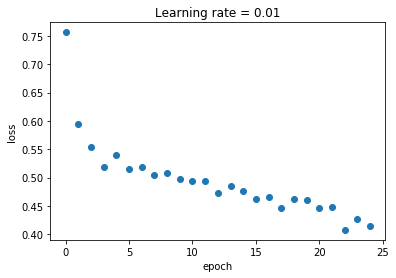

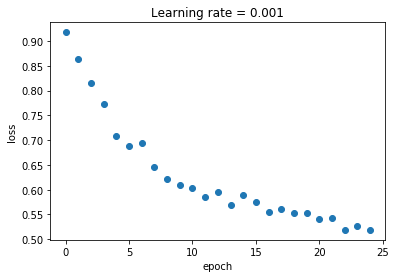

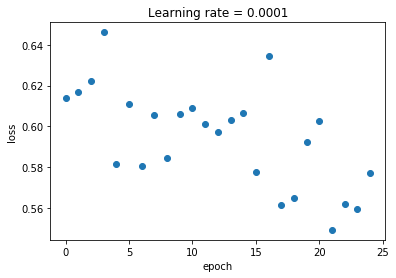

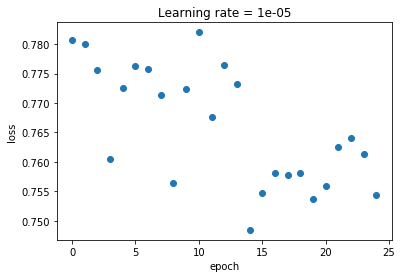

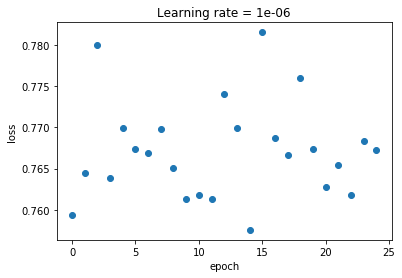

Lowest loss =  0.41438591480255127


In [10]:
# Let us take a look at the loss history to verify training
for lr, lossHist in lossHistories.items():
    plt.plot((np.arange(len(lossHist))),lossHist, 'o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Learning rate = '+ lr)
    plt.show()
print('Lowest loss = ', str(bestLossHistory[len(bestLossHistory)-1]))

### Insight:
Looks like best training occurs at about 1e-2 so will explore randomly about this point.

In [44]:
x_train = X_train[:50,:,:,:]
y_train = Y_train[:50, :,:,:]
print_every = 1
bestPerf = -1
bestLossHistory = None
lossHistories = {}
print_every = 1
bestModel = None
bestLoss = 10000
lrUsed = 0
lrs = [.07571885998409619] # Best result from previous random searches
for i in range(10):
     lrs.append(.1*np.random.random())
for lr in lrs:
    print('About to try lr = ', str(lr))
    groupNormModel = GroupNormUNet()
    optimizer = optim.Adam(groupNormModel.parameters(), lr = lr)
    modelPerf, lossHistory = trainModel(groupNormModel, x_train, y_train, optimizer, epochs = 25, noVal = True)
    lossHistories[str(lr)] = lossHistory
    if lossHistory[len(lossHistory)-1] < bestLoss:
        bestLoss = lossHistory[len(lossHistory)-1]
        bestPerf = modelPerf
        bestLossHistory = lossHistory
        bestModel = groupNormModel
        lrUsed = lr

About to try lr =  0.07571885998409619
Epoch 0, Iteration 0, loss = 0.8976
Train percent correct at epoch 0 is 0.7466
Epoch 1, Iteration 0, loss = 0.5913
Train percent correct at epoch 1 is 0.8411
Epoch 2, Iteration 0, loss = 0.5375
Train percent correct at epoch 2 is 0.8454
Epoch 3, Iteration 0, loss = 0.5108
Train percent correct at epoch 3 is 0.8478
Epoch 4, Iteration 0, loss = 0.5145
Train percent correct at epoch 4 is 0.8553
Epoch 5, Iteration 0, loss = 0.4821
Train percent correct at epoch 5 is 0.8829
Epoch 6, Iteration 0, loss = 0.4621
Train percent correct at epoch 6 is 0.9031
Epoch 7, Iteration 0, loss = 0.4574
Train percent correct at epoch 7 is 0.9178
Epoch 8, Iteration 0, loss = 0.4313
Train percent correct at epoch 8 is 0.9221
Epoch 9, Iteration 0, loss = 0.4025
Train percent correct at epoch 9 is 0.9217
Epoch 10, Iteration 0, loss = 0.3583
Train percent correct at epoch 10 is 0.9267
Epoch 11, Iteration 0, loss = 0.3592
Train percent correct at epoch 11 is 0.9294
Epoch 12,

Epoch 0, Iteration 0, loss = 0.7556
Train percent correct at epoch 0 is 0.8211
Epoch 1, Iteration 0, loss = 0.6203
Train percent correct at epoch 1 is 0.8560
Epoch 2, Iteration 0, loss = 0.5881
Train percent correct at epoch 2 is 0.8745
Epoch 3, Iteration 0, loss = 0.5520
Train percent correct at epoch 3 is 0.9016
Epoch 4, Iteration 0, loss = 0.5288
Train percent correct at epoch 4 is 0.9158
Epoch 5, Iteration 0, loss = 0.5131
Train percent correct at epoch 5 is 0.9205
Epoch 6, Iteration 0, loss = 0.4894
Train percent correct at epoch 6 is 0.9228
Epoch 7, Iteration 0, loss = 0.4808
Train percent correct at epoch 7 is 0.9235
Epoch 8, Iteration 0, loss = 0.4812
Train percent correct at epoch 8 is 0.9270
Epoch 9, Iteration 0, loss = 0.4497
Train percent correct at epoch 9 is 0.9308
Epoch 10, Iteration 0, loss = 0.4597
Train percent correct at epoch 10 is 0.9331
Epoch 11, Iteration 0, loss = 0.4441
Train percent correct at epoch 11 is 0.9346
Epoch 12, Iteration 0, loss = 0.4181
Train perce

Epoch 1, Iteration 0, loss = 0.5973
Train percent correct at epoch 1 is 0.8281
Epoch 2, Iteration 0, loss = 0.5836
Train percent correct at epoch 2 is 0.8356
Epoch 3, Iteration 0, loss = 0.5775
Train percent correct at epoch 3 is 0.8410
Epoch 4, Iteration 0, loss = 0.4952
Train percent correct at epoch 4 is 0.8466
Epoch 5, Iteration 0, loss = 0.5086
Train percent correct at epoch 5 is 0.8678
Epoch 6, Iteration 0, loss = 0.4920
Train percent correct at epoch 6 is 0.9324
Epoch 7, Iteration 0, loss = 0.4464
Train percent correct at epoch 7 is 0.7819
Epoch 8, Iteration 0, loss = 0.5171
Train percent correct at epoch 8 is 0.9217
Epoch 9, Iteration 0, loss = 0.4216
Train percent correct at epoch 9 is 0.8818
Epoch 10, Iteration 0, loss = 0.4363
Train percent correct at epoch 10 is 0.8683
Epoch 11, Iteration 0, loss = 0.4928
Train percent correct at epoch 11 is 0.8677
Epoch 12, Iteration 0, loss = 0.4478
Train percent correct at epoch 12 is 0.8700
Epoch 13, Iteration 0, loss = 0.4661
Train per

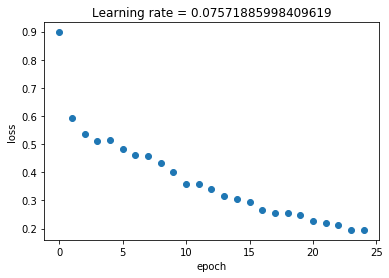

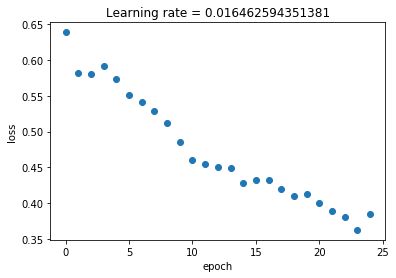

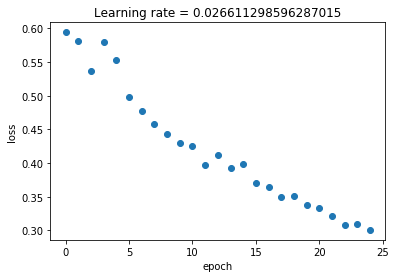

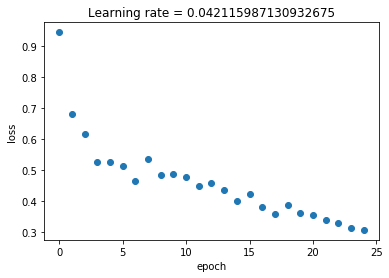

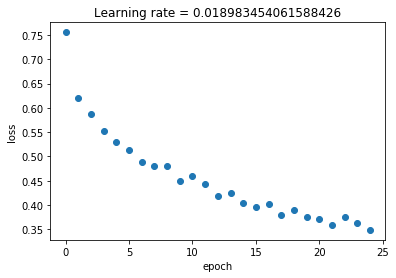

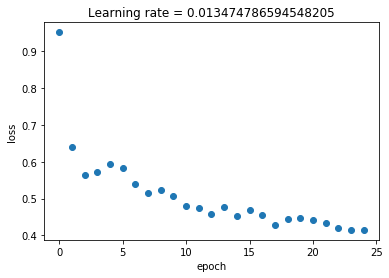

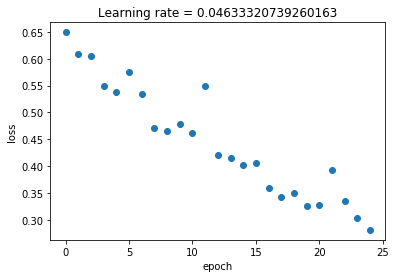

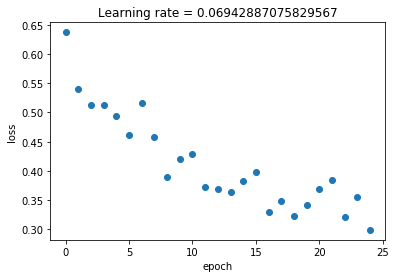

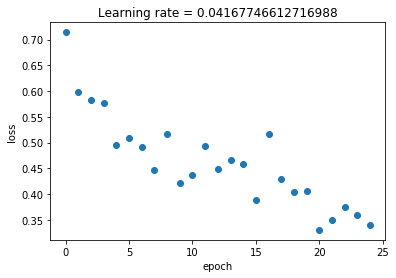

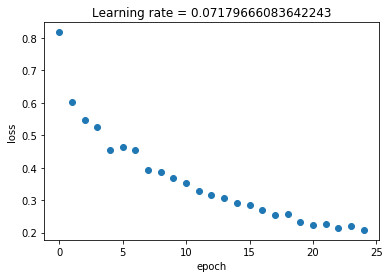

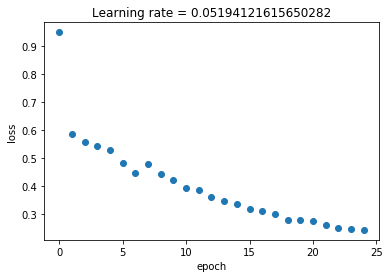

Lowest loss =  0.1949985921382904
Learning rate used =  0.07571885998409619


In [46]:
# Let us take a look at the loss history to verify training
for lr, lossHist in lossHistories.items():
    plt.plot((np.arange(len(lossHist))),lossHist, 'o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Learning rate = '+ lr)
    plt.show()
print('Lowest loss = ', str(bestLossHistory[len(bestLossHistory)-1]))
print('Learning rate used = ', str(lrUsed))

Epoch 0, Iteration 0, loss = 0.7846
Epoch 0, Iteration 1, loss = 0.9379
Epoch 0, Iteration 2, loss = 0.8138
Epoch 0, Iteration 3, loss = 0.5900
Epoch 0, Iteration 4, loss = 0.5126
Epoch 0, Iteration 5, loss = 0.4946
Epoch 0, Iteration 6, loss = 0.4489
Train percent correct at epoch 0 is 0.9161
Epoch 1, Iteration 0, loss = 0.4471
Epoch 1, Iteration 1, loss = 0.4394
Epoch 1, Iteration 2, loss = 0.4159
Epoch 1, Iteration 3, loss = 0.4079
Epoch 1, Iteration 4, loss = 0.3803
Epoch 1, Iteration 5, loss = 0.3697
Epoch 1, Iteration 6, loss = 0.3491
Train percent correct at epoch 1 is 0.9098
Epoch 2, Iteration 0, loss = 0.3406
Epoch 2, Iteration 1, loss = 0.3249
Epoch 2, Iteration 2, loss = 0.3264
Epoch 2, Iteration 3, loss = 0.3080
Epoch 2, Iteration 4, loss = 0.3065
Epoch 2, Iteration 5, loss = 0.2989
Epoch 2, Iteration 6, loss = 0.2836
Train percent correct at epoch 2 is 0.9105
Epoch 3, Iteration 0, loss = 0.2909
Epoch 3, Iteration 1, loss = 0.2875
Epoch 3, Iteration 2, loss = 0.2544
Epoch 3

Epoch 27, Iteration 3, loss = 0.1213
Epoch 27, Iteration 4, loss = 0.1161
Epoch 27, Iteration 5, loss = 0.1135
Epoch 27, Iteration 6, loss = 0.0959
Train percent correct at epoch 27 is 0.9638
Epoch 28, Iteration 0, loss = 0.0987
Epoch 28, Iteration 1, loss = 0.1144
Epoch 28, Iteration 2, loss = 0.1025
Epoch 28, Iteration 3, loss = 0.0931
Epoch 28, Iteration 4, loss = 0.1054
Epoch 28, Iteration 5, loss = 0.1090
Epoch 28, Iteration 6, loss = 0.1181
Train percent correct at epoch 28 is 0.9633
Epoch 29, Iteration 0, loss = 0.1072
Epoch 29, Iteration 1, loss = 0.1108
Epoch 29, Iteration 2, loss = 0.1072
Epoch 29, Iteration 3, loss = 0.0837
Epoch 29, Iteration 4, loss = 0.1104
Epoch 29, Iteration 5, loss = 0.1221
Epoch 29, Iteration 6, loss = 0.1344
Train percent correct at epoch 29 is 0.9609
Epoch 30, Iteration 0, loss = 0.1138
Epoch 30, Iteration 1, loss = 0.1128
Epoch 30, Iteration 2, loss = 0.1073
Epoch 30, Iteration 3, loss = 0.1119
Epoch 30, Iteration 4, loss = 0.1314
Epoch 30, Iterati

Epoch 54, Iteration 4, loss = 0.0922
Epoch 54, Iteration 5, loss = 0.0975
Epoch 54, Iteration 6, loss = 0.0680
Train percent correct at epoch 54 is 0.9702
Epoch 55, Iteration 0, loss = 0.0899
Epoch 55, Iteration 1, loss = 0.0904
Epoch 55, Iteration 2, loss = 0.1075
Epoch 55, Iteration 3, loss = 0.0645
Epoch 55, Iteration 4, loss = 0.0757
Epoch 55, Iteration 5, loss = 0.0851
Epoch 55, Iteration 6, loss = 0.0966
Train percent correct at epoch 55 is 0.9708
Epoch 56, Iteration 0, loss = 0.0700
Epoch 56, Iteration 1, loss = 0.1079
Epoch 56, Iteration 2, loss = 0.0708
Epoch 56, Iteration 3, loss = 0.1043
Epoch 56, Iteration 4, loss = 0.0921
Epoch 56, Iteration 5, loss = 0.1037
Epoch 56, Iteration 6, loss = 0.0737
Train percent correct at epoch 56 is 0.9676
Epoch 57, Iteration 0, loss = 0.1059
Epoch 57, Iteration 1, loss = 0.0626
Epoch 57, Iteration 2, loss = 0.1011
Epoch 57, Iteration 3, loss = 0.0775
Epoch 57, Iteration 4, loss = 0.1042
Epoch 57, Iteration 5, loss = 0.0807
Epoch 57, Iterati

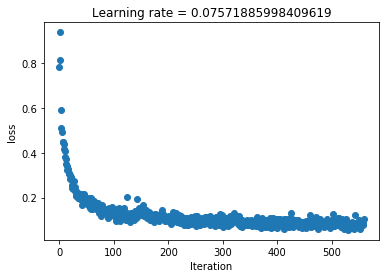

In [48]:
groupNormModel = GroupNormUNet()
optimizer = optim.Adam(groupNormModel.parameters(), lr = lrUsed)
modelPerf, lossHistory = trainModel(groupNormModel, X_train, Y_train, optimizer, epochs = 80, noVal = True)
plt.plot((np.arange(len(lossHistory))),lossHistory, 'o')
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Learning rate = '+ str(lrUsed))
plt.show()

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


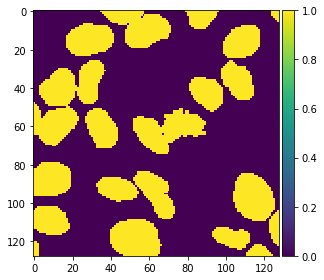

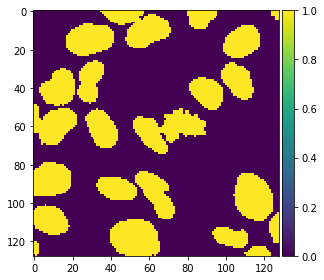

Percentage correct on train set =  0.9705418828708022
Percentage correct on val set =  0.9556196981401586


In [58]:
# Let us visualize how different our predicted masks are
print('Percentage correct on train set = ', calculatePerformance(X_train, Y_train, groupNormModel, visual = True))
print('Percentage correct on val set = ', calculatePerformance(X_val, Y_val, groupNormModel, visual = False))

In [59]:
# Let us now compare to layer norm
layerNormModel = torch.load('layerNormModel')
print('Percentage correct on train set = ', calculatePerformance(X_train, Y_train, layerNormModel, visual = False))
print('Percentage correct on val set = ', calculatePerformance(X_val, Y_val, layerNormModel, visual = False))

Percentage correct on train set =  0.9827721439190765
Percentage correct on val set =  0.9523707147854478


In [51]:
# Let us now compare to baseline model
baselineModel = torch.load('baselineModel')
print('Percentage correct on train set = ', calculatePerformance(X_train, Y_train, baselineModel, visual = False))
print('Percentage correct on val set = ', calculatePerformance(X_val, Y_val, baselineModel, visual = False))

Percentage correct on train set =  0.9685116288673818
Percentage correct on val set =  0.9599504613164646


In [52]:
torch.save(groupNormModel, 'groupNormModel')

# References
[1] Amdal-Saevik, K. (2018). Keras U-Net starter - LB 0.277. 
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855/code

[2] Ho, D. J., Fu, C., Salama, P., Dunn, K. W., and Delp, E. J. (2017, July). Nuclei Segmentation of Fluorescence Microscopy Images Using Three Dimensional Convolutional Neural Networks. In Computer Vision and Pattern Recognition Workshops (CVPRW), 2017 IEEE Conference on (pp. 834-842). IEEE.

[3] Kakade, A., and Dumbali, J. (2018, February). Identification of nerve in ultrasound images using U-net architecture. In 2018 International Conference on Communication information and Computing Technology (ICCICT) (pp. 1-6). IEEE.

[4] Li, X., Chen, H., Qi, X., Dou, Q., Fu, C. W., and Heng, P. A. (2017). H-DenseUNet: Hybrid densely connected UNet for liver and liver tumor segmentation from CT volumes. arXiv preprint arXiv:1709.07330.

[5] Ronneberger, O., Fischer, P., and Brox, T. 
(2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

[6] Pearce, C. Convolutional (2017). Neural Networks and the Analysis of Cancer Imagery.

[7] Imagenet. https://patrykchrabaszcz.github.io/Imagenet32/